# HomeTown Quotes Notebook

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

from xgboost import XGBClassifier
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
from utils import *

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_excel("OctBidsSeenOnce.xlsx")

In [4]:
df.head(5)

,id,product,create_date,TheHour,TheDay,DayName,affiliate_id,affiliate_account_id,source,sub,bidamount,BidType,won_ping,consumer_ip_address,consumer_user_agent,city,state,zipcode,owns_home,months_in_residence,carrier_id,current_coverage_expiration,current_months_with_carrier,credit_type,license_valid,license_obtained_age,gender_type,marital_status_type,relationship_type,occupation,education_level,license_status,military_experience,bankruptcy,sr_22,mileage,use_type,commute_mileage,car_owned,coverage_type,comprehensive_deductible,collision_deductible,current_coverage,lead_certification_id,buyercid,NumVehicles,NumDrivers,expected_revenue
0,3632159922,AUTO,2023-10-10 00:00:03,0,10,Tuesday,2154,14068,14990100,Organic,6.28,LEG,0,75.167.22.219,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Chandler,AZ,85249,1,12,313.0,2023-10-23,28.0,GOOD,1,16,MALE,MARRIED,SELF,OTHER,SOME_OR_NO_HIGH_SCHOOL,ACTIVE,NO_MILITARY_EXPERIENCE,0,0,12500,COMMUTE_WORK,40,1,MINIMUM,50000,50000,1,D3E4C597-671D-7585-E27F-AA12EAF9433D,347.0,2,1,12.6
1,3632160078,AUTO,2023-10-10 00:00:28,0,10,Tuesday,1027,5232,Ig-8OzzwlDEYYckgQ7iq9HFV45W_qA,NaN,5.17,LEG,0,207.200.46.217,User Agent Not Available,Streator,IL,61364,0,0,313.0,2023-10-09,24.0,GOOD,1,16,MALE,MARRIED,SELF,OTHER,ASSOCIATES_DEGREE,ACTIVE,NO_MILITARY_EXPERIENCE,0,0,12500,VARIES,20,0,MINIMUM,10000,10000,1,1D145E0D-539B-043F-21C0-EB88A6E952BE,347.0,1,1,12.6
2,3632163844,AUTO,2023-10-10 00:11:32,0,10,Tuesday,2154,14068,14990100,Organic,5.71,LEG,0,147.219.76.110,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,Madison,WI,53719,0,12,218.0,2023-10-23,28.0,GOOD,1,16,FEMALE,SINGLE,SELF,OTHER,SOME_OR_NO_HIGH_SCHOOL,ACTIVE,NO_MILITARY_EXPERIENCE,0,0,12500,COMMUTE_WORK,40,1,MINIMUM,50000,50000,1,377B06F6-B870-9B2D-62B0-BEEBD5205A19,347.0,1,1,12.6
3,3632166774,AUTO,2023-10-10 00:19:34,0,10,Tuesday,1031,14315,94eca5b76e823a5d6e7628b51510de20,NaN,5.48,LEG,1,172.58.87.221,Mozilla/5.0 (iPhone; CPU iPhone OS 16_6_1 like...,Minneapolis,MN,55412,0,24,313.0,2023-10-17,12.0,FAIR,1,18,MALE,SINGLE,SELF,OTHER,BACHELORS_DEGREE,ACTIVE,NO_MILITARY_EXPERIENCE,0,0,12500,COMMUTE_WORK,15,1,STANDARD,50000,50000,1,CEB82C8D-054B-8FC6-072B-7130430815F8,347.0,2,1,12.6
4,3632167194,AUTO,2023-10-10 00:20:52,0,10,Tuesday,1031,14315,94eca5b76e823a5d6e7628b51510de20,NaN,5.79,LEG,1,108.147.101.24,Mozilla/5.0 (iPhone; CPU iPhone OS 16_7 like M...,Danville,IL,61832,0,24,313.0,2023-10-17,12.0,FAIR,1,18,FEMALE,SINGLE,SELF,OTHER,BACHELORS_DEGREE,ACTIVE,NO_MILITARY_EXPERIENCE,0,0,12500,COMMUTE_WORK,15,1,STANDARD,50000,50000,1,05C01EEC-06CE-5797-A978-5CB8CC21E271,347.0,1,1,12.6


In [5]:
df.shape

(50194, 48)

## Data Exploration

### Data Cleaning

Remove unnecessary columns

product is always AUTO so we can remove it from df. Sub has many null, remove it.



In [6]:
df = df.drop(columns=['id', 'create_date', 'consumer_ip_address', 
                      'consumer_user_agent', 'lead_certification_id', 
                      'product', 'sub', 'buyercid', 'carrier_id', 'city', 'zipcode', 'current_coverage_expiration',
                     'expected_revenue', 'source', 'TheDay', 'affiliate_account_id', 'BidType'])

For carrier, we can only remove the 145 rows with missing data.

In [7]:
numerical_columns, categorical_columns = categorize_columns(df, 'won_ping')

Numerical variables (19): ['TheHour', 'affiliate_id', 'bidamount', 'won_ping', 'owns_home', 'months_in_residence', 'current_months_with_carrier', 'license_valid', 'license_obtained_age', 'bankruptcy', 'sr_22', 'mileage', 'commute_mileage', 'car_owned', 'comprehensive_deductible', 'collision_deductible', 'current_coverage', 'NumVehicles', 'NumDrivers']
Categorical variables (12): ['DayName', 'state', 'credit_type', 'gender_type', 'marital_status_type', 'relationship_type', 'occupation', 'education_level', 'license_status', 'military_experience', 'use_type', 'coverage_type']


In [8]:
no_missing = handle_missing_data(df, categorical_columns, numerical_columns)

In [9]:
inspect_columns(no_missing)

,total_rows,rows_with_missing_values,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
TheHour,50194,0,False,24,False,0.0,0,14,23,int64
DayName,50194,0,False,7,False,0.0,Tuesday,Tuesday,Tuesday,object
affiliate_id,50194,0,False,16,False,0.0,2154,1031,2113,int64
bidamount,50194,0,False,1008,False,0.0,6.28,5.99,3.8,float64
won_ping,50194,0,False,2,False,0.0,0,0,0,int64
state,50194,0,False,49,False,0.0,AZ,PA,GA,object
owns_home,50194,0,False,2,False,0.0,1,0,0,int64
months_in_residence,50194,0,False,20,False,0.0,12,12,12,int64
current_months_with_carrier,50194,0,False,44,False,0.0,28.0,24.0,47.0,float64
credit_type,50194,0,False,4,False,0.0,GOOD,FAIR,GOOD,object


### One Hot Encode

In [10]:
label_columns = ['affiliate_id', 'state', 'credit_type', 'gender_type', 'marital_status_type', 'relationship_type', 'occupation', 'education_level', 'license_status', 'military_experience', 'use_type', 'coverage_type']
hot_encoded, encoder = one_hot_encode_labels(no_missing, label_columns)

/Users/valentingarnier/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [11]:
hot_encoded.head(5)

,TheHour,DayName,bidamount,won_ping,owns_home,months_in_residence,current_months_with_carrier,license_valid,license_obtained_age,bankruptcy,sr_22,mileage,commute_mileage,car_owned,comprehensive_deductible,collision_deductible,current_coverage,NumVehicles,NumDrivers,affiliate_id_1031,affiliate_id_1036,affiliate_id_1043,affiliate_id_2113,affiliate_id_2116,affiliate_id_2128,affiliate_id_2154,affiliate_id_2165,affiliate_id_2238,affiliate_id_2254,affiliate_id_2257,affiliate_id_2258,affiliate_id_2259,affiliate_id_2261,affiliate_id_2262,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,credit_type_FAIR,credit_type_GOOD,credit_type_POOR,gender_type_MALE,gender_type_NONBINARY,marital_status_type_MARRIED,marital_status_type_SEPARATED,marital_status_type_SINGLE,marital_status_type_WIDOWED,relationship_type_SELF,relationship_type_SPOUSE,occupation_CLERGY,occupation_CLERICAL,occupation_CONSTRUCTION_TRADE_LABORER,occupation_DISABLED,occupation_DOCTOR_DENTIST,occupation_EDUCATION_TRAINING,occupation_ENGINEER_SCIENTIST,occupation_HOMEMAKER,occupation_LAWYER_JUDGE,occupation_MILITARY_OTHER,occupation_OTHER,occupation_PRODUCTION_MANUFACTURING,occupation_RETAIL_SALES,occupation_RETIRED,occupation_SALES_OUTSIDE,occupation_SELF_EMPLOYED_BUSINESS_OWNER,occupation_SKILLED_WORKER,occupation_STUDENT_NOT_LIVING_W_PARENTS,occupation_UNEMPLOYED,education_level_BACHELORS_DEGREE,education_level_DOCTORATE_DEGREE,education_level_HIGH_SCHOOL_DIPLOMA,education_level_MASTERS_DEGREE,education_level_OTHER,education_level_SOME_COLLEGE,education_level_SOME_OR_NO_HIGH_SCHOOL,military_experience_OTHER,use_type_COMMUTE_SCHOOL,use_type_COMMUTE_WORK,use_type_PLEASURE,use_type_VARIES,coverage_type_MINIMUM,coverage_type_STANDARD,coverage_type_SUPERIOR
0,0,Tuesday,6.28,0,1,12,28.0,1,16,0,0,12500,40,1,50000,50000,1,2,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0,Tuesday,5.17,0,0,0,24.0,1,16,0,0,12500,20,0,10000,10000,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0,Tuesday,5.71,0,0,12,28.0,1,16,0,0,12500,40,1,50000,50000,1,1,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0,Tuesday,5.48,1,0,24,12.0,1,18,0,0,12500,15,1,50000,50000,1,2,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

### Scale the numerical data

In [12]:
numerical_columns = [x for x in numerical_columns if (x != 'bidamount') and (x != 'TheHour') and (x != 'affiliate_id')]

In [13]:
scaled, scaler = minmax_scale_data(hot_encoded, numerical_columns, feature_range=(0, 1))

In [14]:
day_numbers = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday' :4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

scaled['DayName'] = scaled['DayName'].apply(lambda x: day_numbers[x])
scaled.head()

,TheHour,DayName,bidamount,won_ping,owns_home,months_in_residence,current_months_with_carrier,license_valid,license_obtained_age,bankruptcy,sr_22,mileage,commute_mileage,car_owned,comprehensive_deductible,collision_deductible,current_coverage,NumVehicles,NumDrivers,affiliate_id_1031,affiliate_id_1036,affiliate_id_1043,affiliate_id_2113,affiliate_id_2116,affiliate_id_2128,affiliate_id_2154,affiliate_id_2165,affiliate_id_2238,affiliate_id_2254,affiliate_id_2257,affiliate_id_2258,affiliate_id_2259,affiliate_id_2261,affiliate_id_2262,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,credit_type_FAIR,credit_type_GOOD,credit_type_POOR,gender_type_MALE,gender_type_NONBINARY,marital_status_type_MARRIED,marital_status_type_SEPARATED,marital_status_type_SINGLE,marital_status_type_WIDOWED,relationship_type_SELF,relationship_type_SPOUSE,occupation_CLERGY,occupation_CLERICAL,occupation_CONSTRUCTION_TRADE_LABORER,occupation_DISABLED,occupation_DOCTOR_DENTIST,occupation_EDUCATION_TRAINING,occupation_ENGINEER_SCIENTIST,occupation_HOMEMAKER,occupation_LAWYER_JUDGE,occupation_MILITARY_OTHER,occupation_OTHER,occupation_PRODUCTION_MANUFACTURING,occupation_RETAIL_SALES,occupation_RETIRED,occupation_SALES_OUTSIDE,occupation_SELF_EMPLOYED_BUSINESS_OWNER,occupation_SKILLED_WORKER,occupation_STUDENT_NOT_LIVING_W_PARENTS,occupation_UNEMPLOYED,education_level_BACHELORS_DEGREE,education_level_DOCTORATE_DEGREE,education_level_HIGH_SCHOOL_DIPLOMA,education_level_MASTERS_DEGREE,education_level_OTHER,education_level_SOME_COLLEGE,education_level_SOME_OR_NO_HIGH_SCHOOL,military_experience_OTHER,use_type_COMMUTE_SCHOOL,use_type_COMMUTE_WORK,use_type_PLEASURE,use_type_VARIES,coverage_type_MINIMUM,coverage_type_STANDARD,coverage_type_SUPERIOR
0,0,2,6.28,0.0,1.0,0.05,0.183007,0.0,0.00,0.0,0.0,0.166667,0.222857,1.0,0.444444,0.444444,1.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0,2,5.17,0.0,0.0,0.00,0.156863,0.0,0.00,0.0,0.0,0.166667,0.108571,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0,2,5.71,0.0,0.0,0.05,0.183007,0.0,0.00,0.0,0.0,0.166667,0.222857,1.0,0.444444,0.444444,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0,2,5.48,1.0,0.0,0.10,0.078431,0.0,0.05,0.0,0.0,0.166667,0.080000,1.0,0.444444,0.444444,1.0,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.

In [98]:
df_new = df[['bidamount', 'sr_22', 'won_ping']]

In [99]:
df_new.head()

,bidamount,sr_22,won_ping
0,6.28,0,0
1,5.17,0,0
2,5.71,0,0
3,5.48,0,1
4,5.79,0,1


In [65]:
label_columns = ['DayName', 'credit_type', 'gender_type']
hot_encoded, encoder = one_hot_encode_labels(df_new, label_columns)

/Users/valentingarnier/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [66]:
hot_encoded.head()

,TheHour,bidamount,won_ping,sr_22,DayName_Monday,DayName_Saturday,DayName_Sunday,DayName_Thursday,DayName_Tuesday,DayName_Wednesday,credit_type_FAIR,credit_type_GOOD,credit_type_POOR,gender_type_MALE,gender_type_NONBINARY
0,0,6.28,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,0,5.71,0,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0,5.62,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,6,2.52,1,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,6,3.36,1,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [100]:
# Split the dataset into features (X) and target variable (y)
X = df_new.drop(columns=['won_ping'])
y = df_new['won_ping']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# Split the dataset into features (X) and target variable (y)
X = hot_encoded.drop(columns=['won_ping'])
y = hot_encoded['won_ping']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a logistic regression model
model = LogisticRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')


Accuracy: 0.658133280207192
Confusion Matrix:
[[3943 1532]
 [1900 2664]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.72      0.70      5475
           1       0.63      0.58      0.61      4564

    accuracy                           0.66     10039
   macro avg       0.65      0.65      0.65     10039
weighted avg       0.66      0.66      0.66     10039



/Users/valentingarnier/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [101]:

import statsmodels.api as sm


# Add a constant term to the independent variables
X_train = sm.add_constant(X_train)

# Fit logistic regression model
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Display the summary of the logistic regression
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.652771
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               won_ping   No. Observations:                40155
Model:                          Logit   Df Residuals:                    40152
Method:                           MLE   Df Model:                            2
Date:                Fri, 01 Dec 2023   Pseudo R-squ.:                 0.04954
Time:                        19:27:47   Log-Likelihood:                -26212.
converged:                       True   LL-Null:                       -27578.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.4368      0.035     41.620      0.000       1.369       1.504
bidamount     -0.3257      0.

In [85]:
# Split the dataset into features (X) and target variable (y)
X = hot_encoded.drop(columns=['won_ping'])
y = hot_encoded['won_ping']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [86]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto").fit(X.drop(columns=['bidamount']))
kmeans.labels_
X['k_means'] = kmeans.labels_

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X[X['k_means'] == 1], y[kmeans.labels_==1], test_size=0.2, random_state=42)

In [91]:
# Add a constant term to the independent variables
X_train = sm.add_constant(X_train)

# Fit logistic regression model
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Display the summary of the logistic regression
print(result.summary())

         Current function value: 0.651202
         Iterations: 35


LinAlgError: Singular matrix

In [106]:
df_new.head()

,bidamount,sr_22,won_ping
0,6.28,0,0
1,5.17,0,0
2,5.71,0,0
3,5.48,0,1
4,5.79,0,1


<Axes: xlabel='bidamount', ylabel='won_ping'>

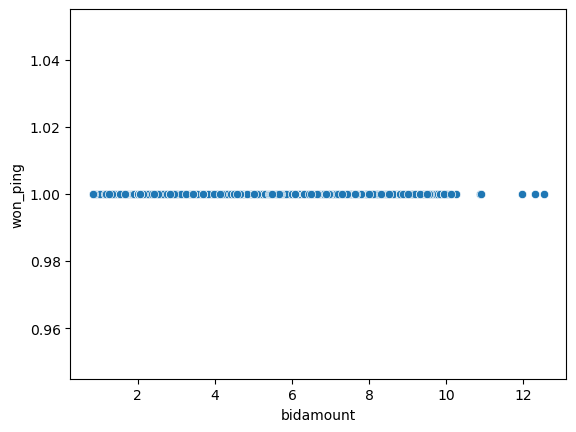

In [107]:
sns.scatterplot(x='bidamount', y='won_ping', data=df_new[df_new['won_ping'] == 1])

## Modelisation

Strategy: Now that the data is cleaned, normalized and encoded, we can apply a model.

* Since there exists no clear relationship between the bidamount and winning, we will train a regression on the bid amount only for those leads that we won.

In [17]:
scaled.shape

(50194, 127)

In [20]:
only_wins = scaled[scaled['won_ping'] == 1]
only_wins = only_wins.drop(columns=['won_ping'])
only_wins.shape

(22381, 126)

### Train - Test Split

In [22]:
X = only_wins.drop(columns='bidamount')
y = only_wins['bidamount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Regression

In [29]:
catboost_model = CatBoostRegressor(iterations=10000,  # You can adjust the number of iterations
                                   learning_rate=0.05,  # You can adjust the learning rate
                                   depth=10,  # You can adjust the depth of the trees
                                   loss_function='RMSE',  # You can choose a different loss function
                                   cat_features=[],  # Specify categorical features if any
                                   random_seed=42  # Set a random seed for reproducibility
                                   )

# Fit the model to the training data
catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=500, verbose=100)

# Make predictions on the test set
y_pred = catboost_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# You can also visualize feature importance if needed
feature_importances = catboost_model.get_feature_importance()
print('Feature Importances:', feature_importances[:5])

0:	learn: 1.4922966	test: 1.5090134	best: 1.5090134 (0)	total: 27.7ms	remaining: 4m 37s
100:	learn: 1.0378936	test: 1.0869058	best: 1.0869058 (100)	total: 1.82s	remaining: 2m 58s
200:	learn: 0.9841941	test: 1.0576627	best: 1.0576627 (200)	total: 3.53s	remaining: 2m 52s
300:	learn: 0.9443165	test: 1.0428321	best: 1.0428321 (300)	total: 5.24s	remaining: 2m 48s
400:	learn: 0.9155509	test: 1.0391704	best: 1.0390747 (396)	total: 6.94s	remaining: 2m 46s
500:	learn: 0.8896822	test: 1.0379239	best: 1.0377402 (489)	total: 8.64s	remaining: 2m 43s
600:	learn: 0.8679299	test: 1.0391069	best: 1.0377402 (489)	total: 10.4s	remaining: 2m 41s
700:	learn: 0.8507347	test: 1.0406417	best: 1.0377402 (489)	total: 12.1s	remaining: 2m 39s
800:	learn: 0.8344481	test: 1.0427889	best: 1.0377402 (489)	total: 14.1s	remaining: 2m 41s
900:	learn: 0.8207186	test: 1.0448592	best: 1.0377402 (489)	total: 16.4s	remaining: 2m 45s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 1.037740158
bestIteration 

Now, we have a model that learned the bid amount for leads that we won. Let's apply this model to test data for leads that we won and on leads that we lost.

In [34]:
X_test['bidamount'] = y_test
X_test['bidamount_predicted'] = y_pred
X_test['won_ping'] = 1

In [35]:
X_test.head()

,TheHour,DayName,owns_home,months_in_residence,current_months_with_carrier,license_valid,license_obtained_age,bankruptcy,sr_22,mileage,commute_mileage,car_owned,comprehensive_deductible,collision_deductible,current_coverage,NumVehicles,NumDrivers,affiliate_id_1031,affiliate_id_1036,affiliate_id_1043,affiliate_id_2113,affiliate_id_2116,affiliate_id_2128,affiliate_id_2154,affiliate_id_2165,affiliate_id_2238,affiliate_id_2254,affiliate_id_2257,affiliate_id_2258,affiliate_id_2259,affiliate_id_2261,affiliate_id_2262,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,credit_type_FAIR,credit_type_GOOD,credit_type_POOR,gender_type_MALE,gender_type_NONBINARY,marital_status_type_MARRIED,marital_status_type_SEPARATED,marital_status_type_SINGLE,marital_status_type_WIDOWED,relationship_type_SELF,relationship_type_SPOUSE,occupation_CLERGY,occupation_CLERICAL,occupation_CONSTRUCTION_TRADE_LABORER,occupation_DISABLED,occupation_DOCTOR_DENTIST,occupation_EDUCATION_TRAINING,occupation_ENGINEER_SCIENTIST,occupation_HOMEMAKER,occupation_LAWYER_JUDGE,occupation_MILITARY_OTHER,occupation_OTHER,occupation_PRODUCTION_MANUFACTURING,occupation_RETAIL_SALES,occupation_RETIRED,occupation_SALES_OUTSIDE,occupation_SELF_EMPLOYED_BUSINESS_OWNER,occupation_SKILLED_WORKER,occupation_STUDENT_NOT_LIVING_W_PARENTS,occupation_UNEMPLOYED,education_level_BACHELORS_DEGREE,education_level_DOCTORATE_DEGREE,education_level_HIGH_SCHOOL_DIPLOMA,education_level_MASTERS_DEGREE,education_level_OTHER,education_level_SOME_COLLEGE,education_level_SOME_OR_NO_HIGH_SCHOOL,military_experience_OTHER,use_type_COMMUTE_SCHOOL,use_type_COMMUTE_WORK,use_type_PLEASURE,use_type_VARIES,coverage_type_MINIMUM,coverage_type_STANDARD,coverage_type_SUPERIOR,bidamount,bidamount_predicted,won_ping
30356,9,5,0.0,0.10,0.078431,0.0,0.05,0.0,0.0,0.166667,0.080000,1.0,0.444444,0.444444,1.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.62,3.592222,1
9323,11,5,0.0,0.10,0.078431,0.0,0.05,0.0,0.0,0.166667,0.080000,1.0,0.444444,0.444444,1.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,6.07,5.677673,1
42905,8,4,1.0,0.05,0.549020,0.0,0.00,0.0,0.0,0.166667,0.022857,1.0,0.444444,0.444444,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.42,2.890179,1
40910,7,2,1.0,0.05,0.862745,0.0,0.00,0.0,0.0,0.166667,0.022857,1.0,0.444444,0.444444,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

Do the same on leads that we lost.

In [73]:
X_test_lost = scaled[scaled['won_ping'] == 0].sample(X_test.shape[0])
y_test_lost = X_test_lost['bidamount']
X_test_lost.drop(columns=['won_ping', 'bidamount'])

y_pred_lost = catboost_model.predict(X_test_lost)

X_test_lost['bidamount'] = y_test_lost
X_test_lost['bidamount_predicted'] = y_pred_lost
X_test_lost['won_ping'] = 0

In [74]:
X_test_lost.head()

,TheHour,DayName,bidamount,won_ping,owns_home,months_in_residence,current_months_with_carrier,license_valid,license_obtained_age,bankruptcy,sr_22,mileage,commute_mileage,car_owned,comprehensive_deductible,collision_deductible,current_coverage,NumVehicles,NumDrivers,affiliate_id_1031,affiliate_id_1036,affiliate_id_1043,affiliate_id_2113,affiliate_id_2116,affiliate_id_2128,affiliate_id_2154,affiliate_id_2165,affiliate_id_2238,affiliate_id_2254,affiliate_id_2257,affiliate_id_2258,affiliate_id_2259,affiliate_id_2261,affiliate_id_2262,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,credit_type_FAIR,credit_type_GOOD,credit_type_POOR,gender_type_MALE,gender_type_NONBINARY,marital_status_type_MARRIED,marital_status_type_SEPARATED,marital_status_type_SINGLE,marital_status_type_WIDOWED,relationship_type_SELF,relationship_type_SPOUSE,occupation_CLERGY,occupation_CLERICAL,occupation_CONSTRUCTION_TRADE_LABORER,occupation_DISABLED,occupation_DOCTOR_DENTIST,occupation_EDUCATION_TRAINING,occupation_ENGINEER_SCIENTIST,occupation_HOMEMAKER,occupation_LAWYER_JUDGE,occupation_MILITARY_OTHER,occupation_OTHER,occupation_PRODUCTION_MANUFACTURING,occupation_RETAIL_SALES,occupation_RETIRED,occupation_SALES_OUTSIDE,occupation_SELF_EMPLOYED_BUSINESS_OWNER,occupation_SKILLED_WORKER,occupation_STUDENT_NOT_LIVING_W_PARENTS,occupation_UNEMPLOYED,education_level_BACHELORS_DEGREE,education_level_DOCTORATE_DEGREE,education_level_HIGH_SCHOOL_DIPLOMA,education_level_MASTERS_DEGREE,education_level_OTHER,education_level_SOME_COLLEGE,education_level_SOME_OR_NO_HIGH_SCHOOL,military_experience_OTHER,use_type_COMMUTE_SCHOOL,use_type_COMMUTE_WORK,use_type_PLEASURE,use_type_VARIES,coverage_type_MINIMUM,coverage_type_STANDARD,coverage_type_SUPERIOR,bidamount_predicted
14259,11,2,5.80,0,1.0,0.250000,0.392157,0.0,0.0,0.0,0.0,0.000000,0.040000,1.0,0.444444,0.444444,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,6.622521
45537,5,2,3.28,0,1.0,0.104167,0.163399,0.0,0.0,0.0,0.0,0.166667,0.062857,1.0,0.166667,0.166667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.121220
11945,10,1,4.78,0,1.0,0.100000,0.150327,0.0,0.0,0.0,0.0,0.166667,0.102857,1.0,0.444444,0.444444,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,4.156020
18307,2,5,6.91,0,0.0,0.050000,0.000000,0.0,0.0,0.0,0.0,0.111111,0.091429,1.0,0.444444,0.444444,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

Union the two test data.

In [76]:
concatenated_test = pd.concat([X_test, X_test_lost])

Check the difference between the bid amount and the prediction from the model and compute the probability.

In [134]:
concatenated_test['abs_diff'] = abs(concatenated_test['bidamount_predicted'] - concatenated_test['bidamount'])
concatenated_test['diff'] = concatenated_test['bidamount'] - concatenated_test['bidamount_predicted']
concatenated_test['diff_percentage'] = (concatenated_test['bidamount'] - concatenated_test['bidamount_predicted']) / (concatenated_test['bidamount_predicted'])
concatenated_test['rounded_diff_percentage'] = round((concatenated_test['bidamount'] - concatenated_test['bidamount_predicted']) / (concatenated_test['bidamount_predicted']), 0)
concatenated_test['custom_rounded_diff_percentage'] = ((concatenated_test['bidamount'] - concatenated_test['bidamount_predicted']) / (concatenated_test['bidamount_predicted'])) // 0.5


concatenated_test['rounded_diff'] = round(concatenated_test['diff'], 0)

In [135]:
concatenated_test.head(5)

,TheHour,DayName,owns_home,months_in_residence,current_months_with_carrier,license_valid,license_obtained_age,bankruptcy,sr_22,mileage,commute_mileage,car_owned,comprehensive_deductible,collision_deductible,current_coverage,NumVehicles,NumDrivers,affiliate_id_1031,affiliate_id_1036,affiliate_id_1043,affiliate_id_2113,affiliate_id_2116,affiliate_id_2128,affiliate_id_2154,affiliate_id_2165,affiliate_id_2238,affiliate_id_2254,affiliate_id_2257,affiliate_id_2258,affiliate_id_2259,affiliate_id_2261,affiliate_id_2262,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,credit_type_FAIR,credit_type_GOOD,credit_type_POOR,gender_type_MALE,gender_type_NONBINARY,marital_status_type_MARRIED,marital_status_type_SEPARATED,marital_status_type_SINGLE,marital_status_type_WIDOWED,relationship_type_SELF,relationship_type_SPOUSE,occupation_CLERGY,occupation_CLERICAL,occupation_CONSTRUCTION_TRADE_LABORER,occupation_DISABLED,occupation_DOCTOR_DENTIST,occupation_EDUCATION_TRAINING,occupation_ENGINEER_SCIENTIST,occupation_HOMEMAKER,occupation_LAWYER_JUDGE,occupation_MILITARY_OTHER,occupation_OTHER,occupation_PRODUCTION_MANUFACTURING,occupation_RETAIL_SALES,occupation_RETIRED,occupation_SALES_OUTSIDE,occupation_SELF_EMPLOYED_BUSINESS_OWNER,occupation_SKILLED_WORKER,occupation_STUDENT_NOT_LIVING_W_PARENTS,occupation_UNEMPLOYED,education_level_BACHELORS_DEGREE,education_level_DOCTORATE_DEGREE,education_level_HIGH_SCHOOL_DIPLOMA,education_level_MASTERS_DEGREE,education_level_OTHER,education_level_SOME_COLLEGE,education_level_SOME_OR_NO_HIGH_SCHOOL,military_experience_OTHER,use_type_COMMUTE_SCHOOL,use_type_COMMUTE_WORK,use_type_PLEASURE,use_type_VARIES,coverage_type_MINIMUM,coverage_type_STANDARD,coverage_type_SUPERIOR,bidamount,bidamount_predicted,won_ping,abs_diff,diff,rounded_diff,diff_percentage,rounded_diff_percentage,custom_rounded_diff_percentage
30356,9,5,0.0,0.10,0.078431,0.0,0.05,0.0,0.0,0.166667,0.080000,1.0,0.444444,0.444444,1.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,3.62,3.592222,1,0.027778,0.027778,0.0,0.007733,0.0,0.0
9323,11,5,0.0,0.10,0.078431,0.0,0.05,0.0,0.0,0.166667,0.080000,1.0,0.444444,0.444444,1.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,6.07,5.677673,1,0.392327,0.392327,0.0,0.069100,0.0,0.0
42905,8,4,1.0,0.05,0.549020,0.0,0.00,0.0,0.0,0.166667,0.022857,1.0,0.444444,0.444444,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.42,2.890179,1,0.470179,-0.470179,-0.0,-0.162681,-0

<Axes: xlabel='diff', ylabel='Count'>

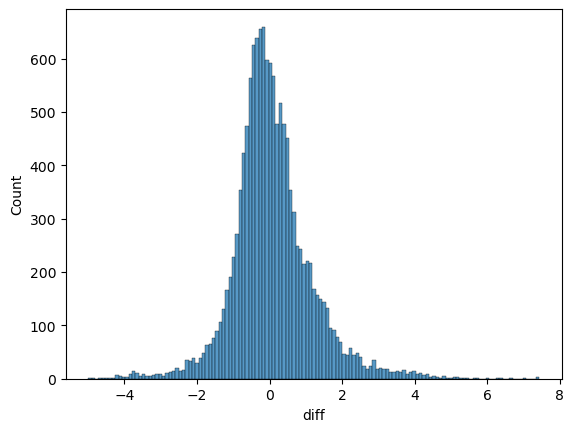

In [119]:
sns.histplot(x='diff', data=concatenated_test)

In [120]:
test = concatenated_test.groupby('rounded_diff')[['won_ping']].agg(lambda x: x.sum() / x.count())

In [121]:
test = test.reset_index()

In [122]:
test

,rounded_diff,won_ping
0,-5.0,0.000000
1,-4.0,0.338710
2,-3.0,0.420561
3,-2.0,0.471239
4,-1.0,0.484848
5,0.0,0.574383
6,1.0,0.384219
7,2.0,0.380407
8,3.0,0.432900
9,4.0,0.663793


Plot to show

<Axes: xlabel='rounded_diff', ylabel='won_ping'>

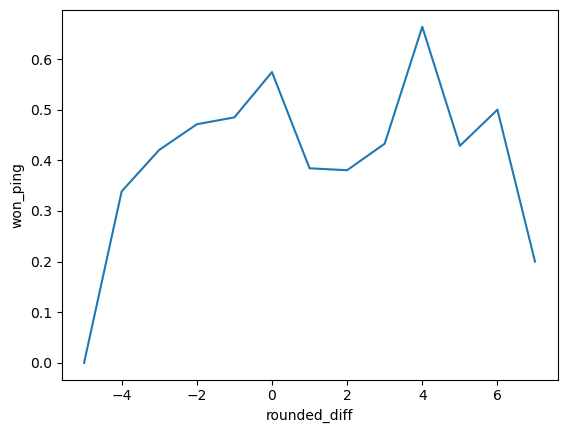

In [123]:
sns.lineplot(x='rounded_diff', y='won_ping', data=test)

What happens when we look with percentage?

In [140]:
test = concatenated_test.groupby('rounded_diff_percentage')[['won_ping']].agg(lambda x: x.sum() / x.count())

In [142]:
test

,won_ping
rounded_diff_percentage,
-1.0,0.517413
0.0,0.496760
1.0,0.588517
2.0,0.750000


<Axes: xlabel='rounded_diff_percentage', ylabel='won_ping'>

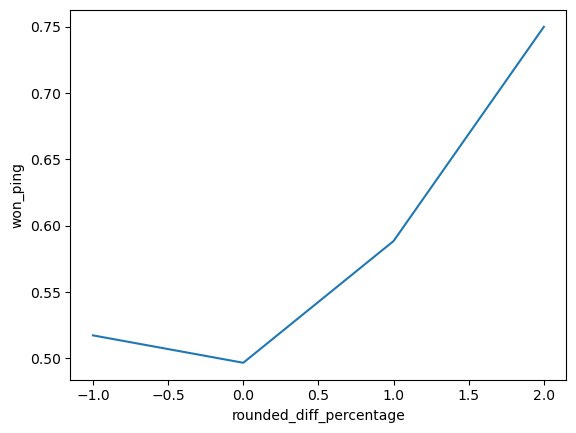

In [141]:
sns.lineplot(x='rounded_diff_percentage', y='won_ping', data=test)

<Axes: xlabel='won_ping', ylabel='diff'>

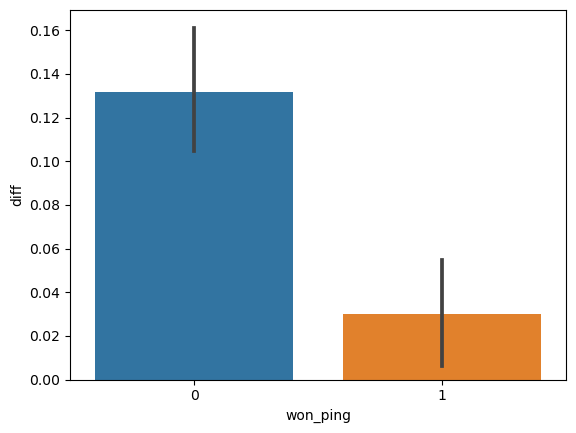

In [100]:
sns.barplot(x='won_ping', y='diff', data=concatenated_test)